# Run hacked AlphaFold2 on the designed bound states

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /home/broerman/crispy_shifty/projects/OPS/round_1/design
running on node: sofia


Note: We want to use perlmutter

### Fix the paths
Necessary because we are on perlmutter

In [3]:
sys.path.insert(0, "/global/cfs/cdirs/m4129/projects/crispy_shifty_adam")
from crispy_shifty.utils.io import fix_path_prefixes

pairs = "/global/cfs/cdirs/m4129/projects/crispy_shifty_adam/projects/OPS/round_1/design/05_mpnn_bound_states/mpnn_states.pair"
new_pairs = fix_path_prefixes(
    find="/home/broerman/crispy_shifty",
    replace="/global/cfs/cdirs/m4129/projects/crispy_shifty_adam",
    file=pairs,
    overwrite=True,
)

/global/cfs/cdirs/m4129/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Run AF2 on the designed bound states

In [9]:
sys.path.insert(0, "/global/cfs/cdirs/m4129/projects/crispy_shifty_adam")
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "06_fold_bound_states"
design_list_file = "/global/cfs/cdirs/m4129/projects/crispy_shifty_adam/projects/OPS/round_1/design/05_mpnn_bound_states/mpnn_states.pair"
output_path = os.path.join(f"/pscratch/sd/b/broerman/{simulation_name}")

options = " ".join(
    [
        "out:level 200",
    ]
)
extra_kwargs = {"models": "1"}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.folding.fold_bound_state",
    design_list_file=design_list_file,
    output_path=output_path,
    perlmutter_mode=True,
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    time="10:00",
)

Run the following command with your desired environment active:
sbatch -a 1-1818 /pscratch/sd/b/broerman/06_fold_bound_states/run.sh


Note: We rsync the perlmutter results, now back on the digs

### Collect scorefiles of the folded bound states and concatenate

In [3]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "06_fold_bound_states"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile

In [4]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

### Dump scores_df as a CSV and then reload, for performance reasons

In [3]:
simulation_name = "06_fold_bound_states"
output_path = os.path.join(
    "/home/broerman/crispy_shifty/projects/OPS/round_1/design", simulation_name
)
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

In [16]:
filt_df = scores_df[scores_df["rmsd_to_reference"] < 1.5]

In [17]:
filt_df

,bb_clash,bb_clash_delta,buns_parent,cms_AcB,cms_AnAc,cms_AnAcB,cms_AnB,designed_by,docked_helix,dslf_fa13,...,state,time,tol,topo,total_length,total_score,trim_n,trimmed_length,type,yhh_planarity
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0006/06_fold_bound_states_f19b4bd67378490fad5b50d6970b2855.pdb.bz2,172.833603,8.311612,0.0,230.515442,236.062180,597.083862,399.178253,mpnn,3,0.0,...,KW_b1_07_repeat_p_4_s_2_d_3,1379.387469,0.882905,HHHHHHHH,193.0,-424.420290,0,165,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0006/06_fold_bound_states_8d6ffe6ac00a41edb41b1b6c9c378dac.pdb.bz2,50.990532,5.447642,0.0,309.852875,324.382080,599.413757,308.429871,rosetta,3,0.0,...,KW_b1_11_DY_p_4_s_1_d_3,1086.709391,1.185032,HHHHHHHH,195.0,-145.818037,0,165,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0006/06_fold_bound_states_2fd4625315dd49a39e9e2873c52c12f5.pdb.bz2,744.504028,2.653062,0.0,320.643433,303.383148,521.868042,216.958359,mpnn,3,0.0,...,KW_b1_11_DY_p_4_s_5_d_3,2362.838273,0.272806,HHHHHHHH,198.0,-216.581442,0,165,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0006/06_fold_bound_states_b481983bc7504b04b2bb8d6b5613f9ed.pdb.bz2,50.990532,1.507389,0.0,284.004272,277.104645,563.538269,281.302917,mpnn,3,0.0,...,KW_b1_11_DY_p_4_s_1_d_3,886.110388,0.323944,HHHHHHHH,195.0,30.719551,0,165,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0006/06_fold_bound_states_5eb1a5d67a754e40ac2c7f9c71b96e68.pdb.bz2,103.028282,4.608621,0.0,123.955734,298.366547,415.555176,303.886658,mpnn,5,0.0,...,KW_b1_07_repeat_p_4_s_-1_d_5,1169.588869,0.136809,HHHHHHHH,194.0,-327.743688,0,165,monomer_ptm,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0036/06_fold_bound_states_ec82df13a3e44832ae6be157ca8f3801.pdb.bz2,313.924591,9.619345,0.0,235.385071,426.177399,354.283295,135.243454,mpnn,8,0.0,...,R6ST3_p_7_s_-1_d_8,1598.789234,0.255667,HHHHHHHHHHHH,282.0,-492.485178,0,255,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0036/06_fold_bound_states_e64a1bb3215d40b0aa0af7be05176b79.pdb.bz2,84.324280,3.543895,0.0,220.691223,839.109741,402.945892,192.521805,mpnn,8,0.0,...,s8_LRT6_p_7_s_-5_d_8,1479.530028,3.818749,HHHHHHHHHHHH,282.0,-638.565284,0,255,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0036/06_fold_bound_states_48553820fff24817b64c2ea2421e8c14.pdb.bz2,693.228149,6.765924,0.0,332.916565,430.530060,495.850281,169.380310,mpnn,6,0.0,...,sl_S2_08_p_7_s_-1_d_6,2347.784090,0.124978,HHHHHHHHHHHH,282.0,-793.921411,0,255,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0036/06_fold_bound_states_03f81ba943ce4edc977eca53004be3ec.pdb.bz2,87.223679,12.893867,0.0,179.780960,829.467468,356.136963,172.835480,mpnn,8,0.0,...,R6_n6_p_7_s_-5_d_8,1746.178076,0.506038,HHHHHHHHHHHH,282.0,-479.390606,0,255,monomer_ptm,0.0


### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [19]:
rosetta = filt_df[filt_df["designed_by"] == "rosetta"]
mpnn = filt_df[filt_df["designed_by"] == "mpnn"].sample(1000, random_state=0)
sample_df = pd.concat([rosetta, mpnn])

In [20]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

1414
['bb_clash', 'bb_clash_delta', 'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'fixed_resis', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_temperature', 'new_loop_str', 'pTMscore', 'packstat_parent', 'parent', 'parent_length', 'path_in', 'pdb', 'pivot_helix', 'pre_break_helix', 'recycles', 'repeat_len', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'score', 'score_per_res', 'score_per_res_parent', 'seed', 'shift', 'ss_sc', 'state', 'time', 'tol', 'topo', 'total_length', 'total_score', 'trim_n', 'trimmed_length', 'type']


In [21]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

to_plot = [
    # from scaffold selection that I didn't use here
    # "best_average_plddts",
    # "best_model",
    # "best_ptm",
    # "best_rmsd_to_input",
    "cms_AcB",
    "cms_AnAc",
    "cms_AnAcB",
    "cms_AnB",
    "designed_by",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_interaction_AB",
    "mean_pae_interaction_BA",
    "mean_pae_intra_chain",
    "mean_pae_intra_chain_A",
    "mean_pae_intra_chain_B",
    "mean_plddt",
    "mismatch_probability_parent",
    "pTMscore",
    "packstat_parent",
    "pdb",
    "recycles",
    "rmsd_to_reference",
    "sap_parent",
    "sc_AcB",
    "sc_AnAc",
    "sc_AnAcB",
    "sc_AnB",
    "sc_all_parent",
    "score_per_res",
    "score_per_res_parent",
    "ss_sc",
    "state",
    "topo",
]
print(to_plot)

['cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'pTMscore', 'packstat_parent', 'pdb', 'recycles', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'score_per_res', 'score_per_res_parent', 'ss_sc', 'state', 'topo']


### Plot before and after interface design AF2 metrics

6it [00:00, 26.49it/s]


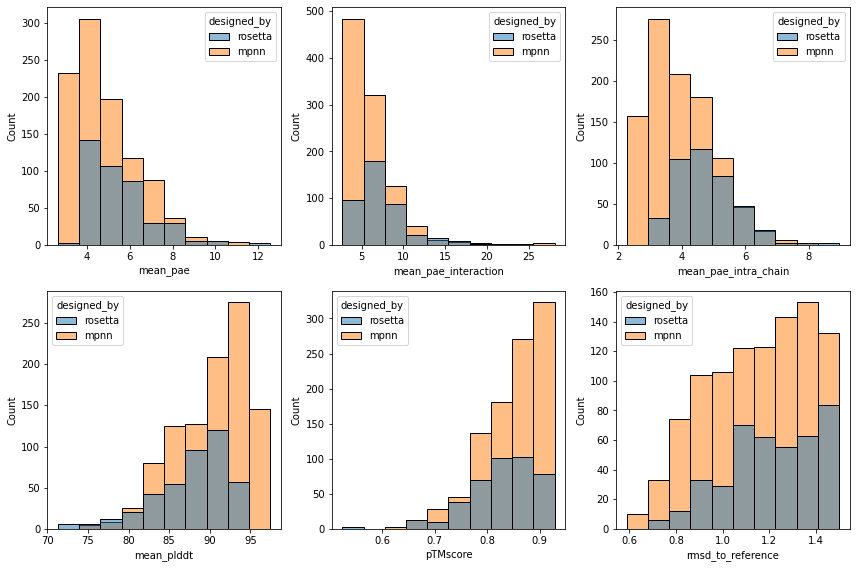

In [22]:
cols = [
    # "best_average_plddts",
    # "best_ptm",
    # "best_rmsd_to_input",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_intra_chain",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores.png"))

<Figure size 1728x1728 with 0 Axes>

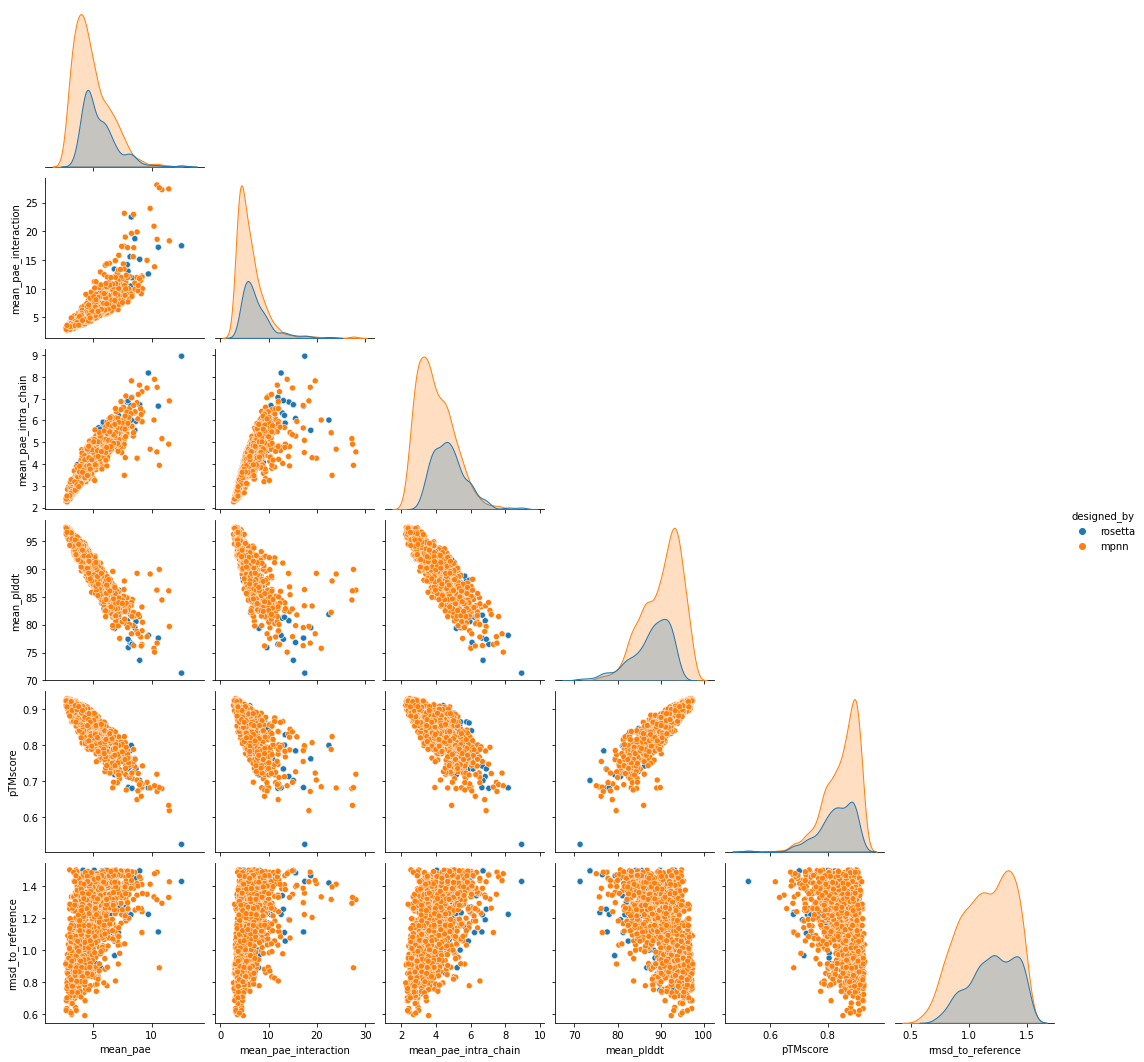

In [23]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_paired.png"))

### Plot effects of MPNN temperature and selector areas on AF2 metrics

6it [00:00, 36.16it/s]


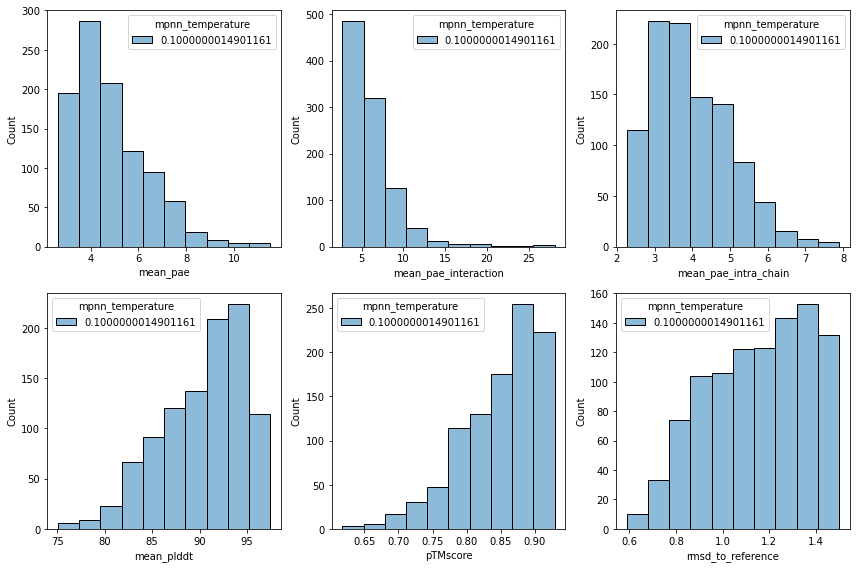

In [24]:
mpnn["mpnn_temperature"] = mpnn["mpnn_temperature"].astype(str)

cols = [
    # "best_average_plddts",
    # "best_ptm",
    # "best_rmsd_to_input",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_intra_chain",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
]
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_temperature",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_temp.png"))

<Figure size 1728x1728 with 0 Axes>

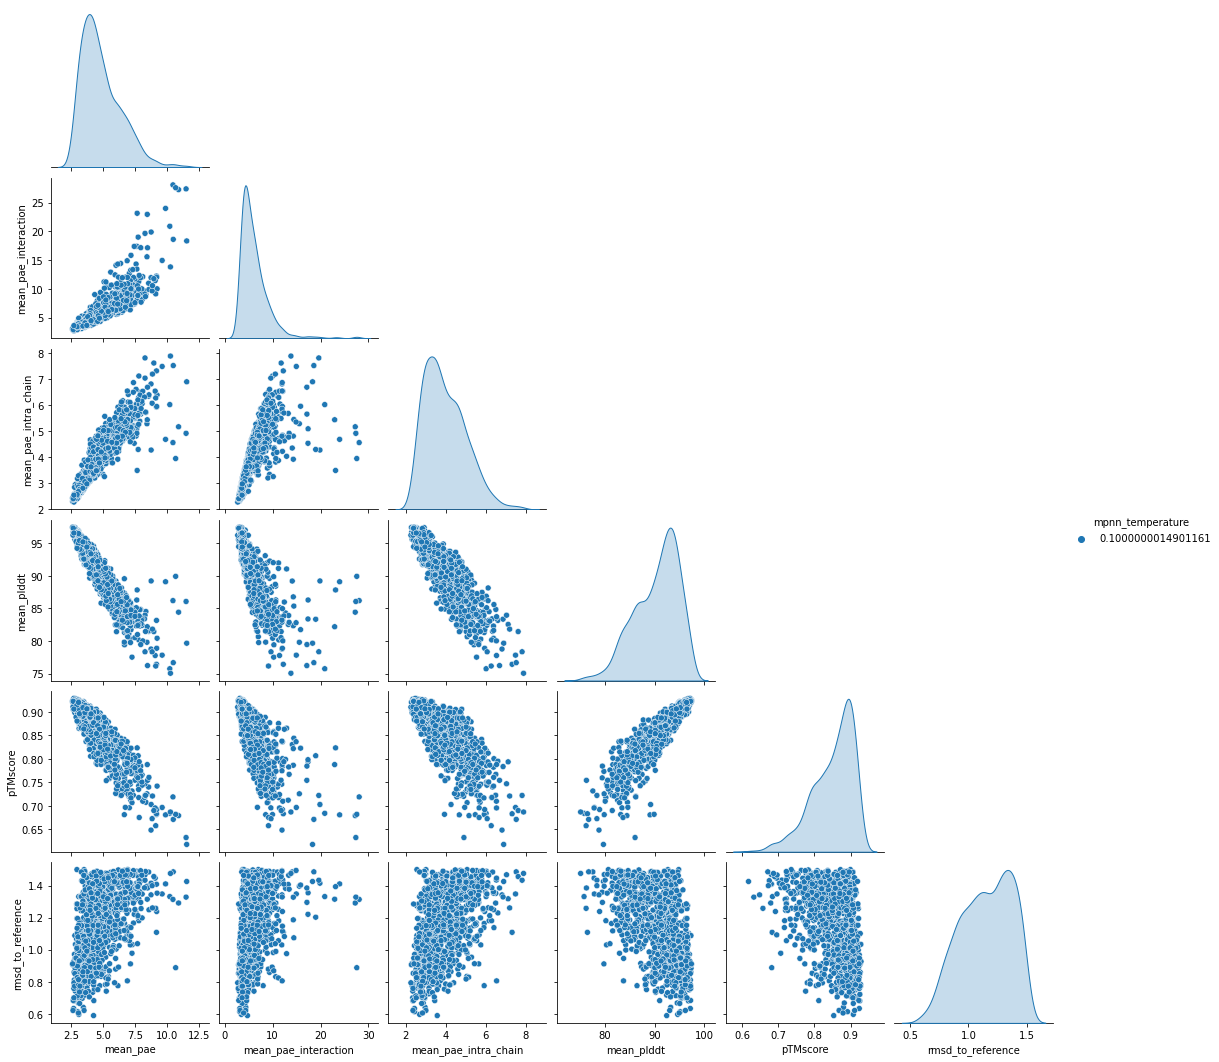

In [25]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_temperature",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_temp_paired.png"))

6it [00:00, 22.51it/s]


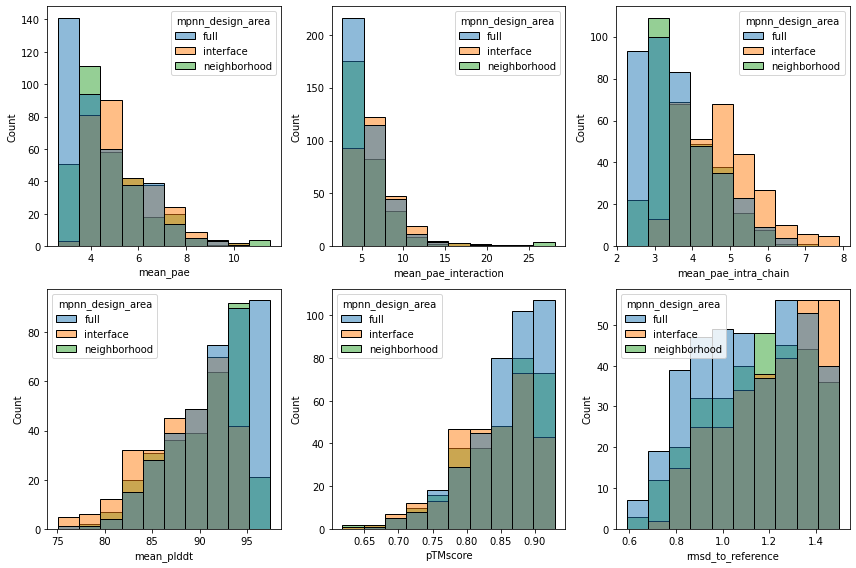

In [26]:
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_design_area",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area.png"))

<Figure size 1728x1728 with 0 Axes>

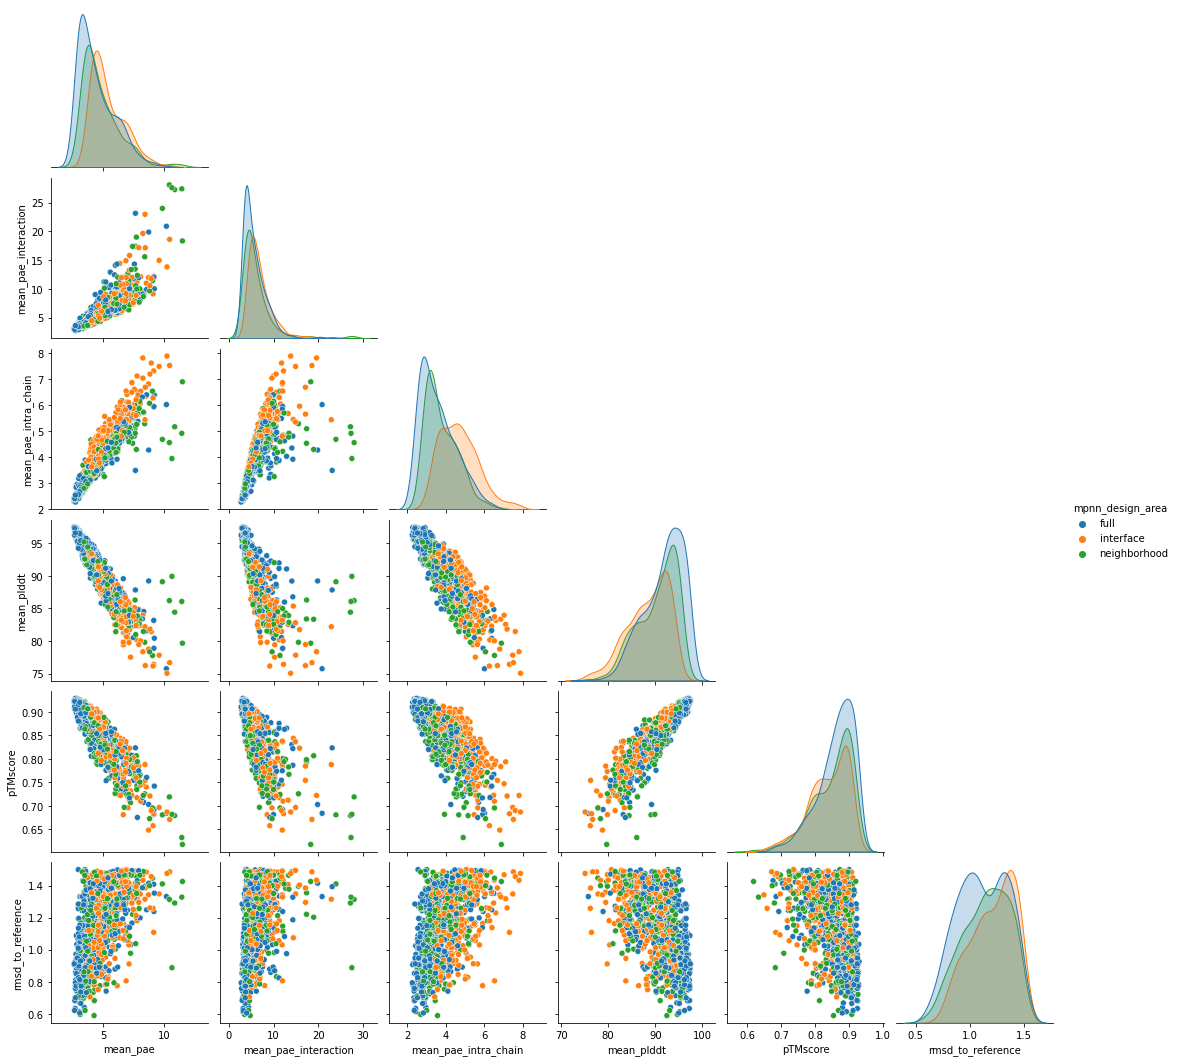

In [27]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_design_area",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area_paired.png"))

### Plot interface metrics

6it [00:00, 26.14it/s]


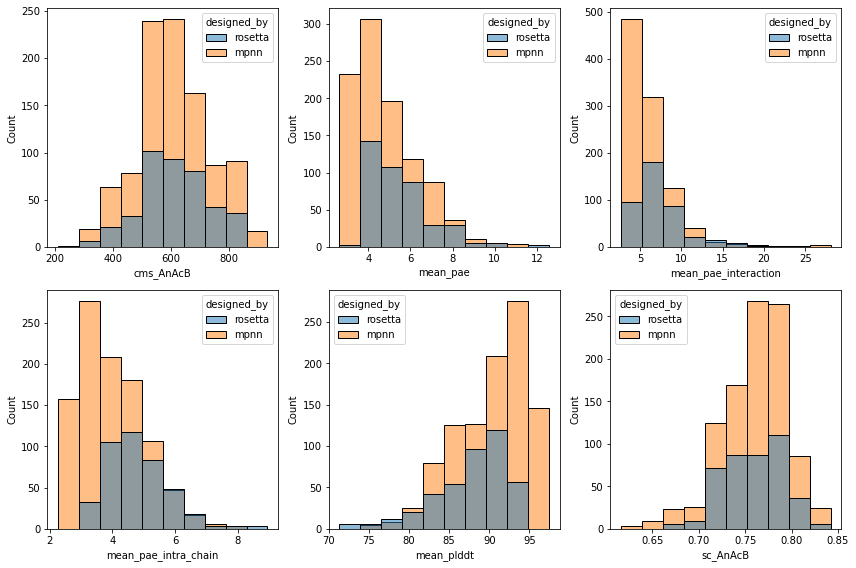

In [28]:
cols = [
    "cms_AnAcB",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_intra_chain",
    "mean_plddt",
    "sc_AnAcB",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "interface_scores.png"))

<Figure size 1728x1728 with 0 Axes>

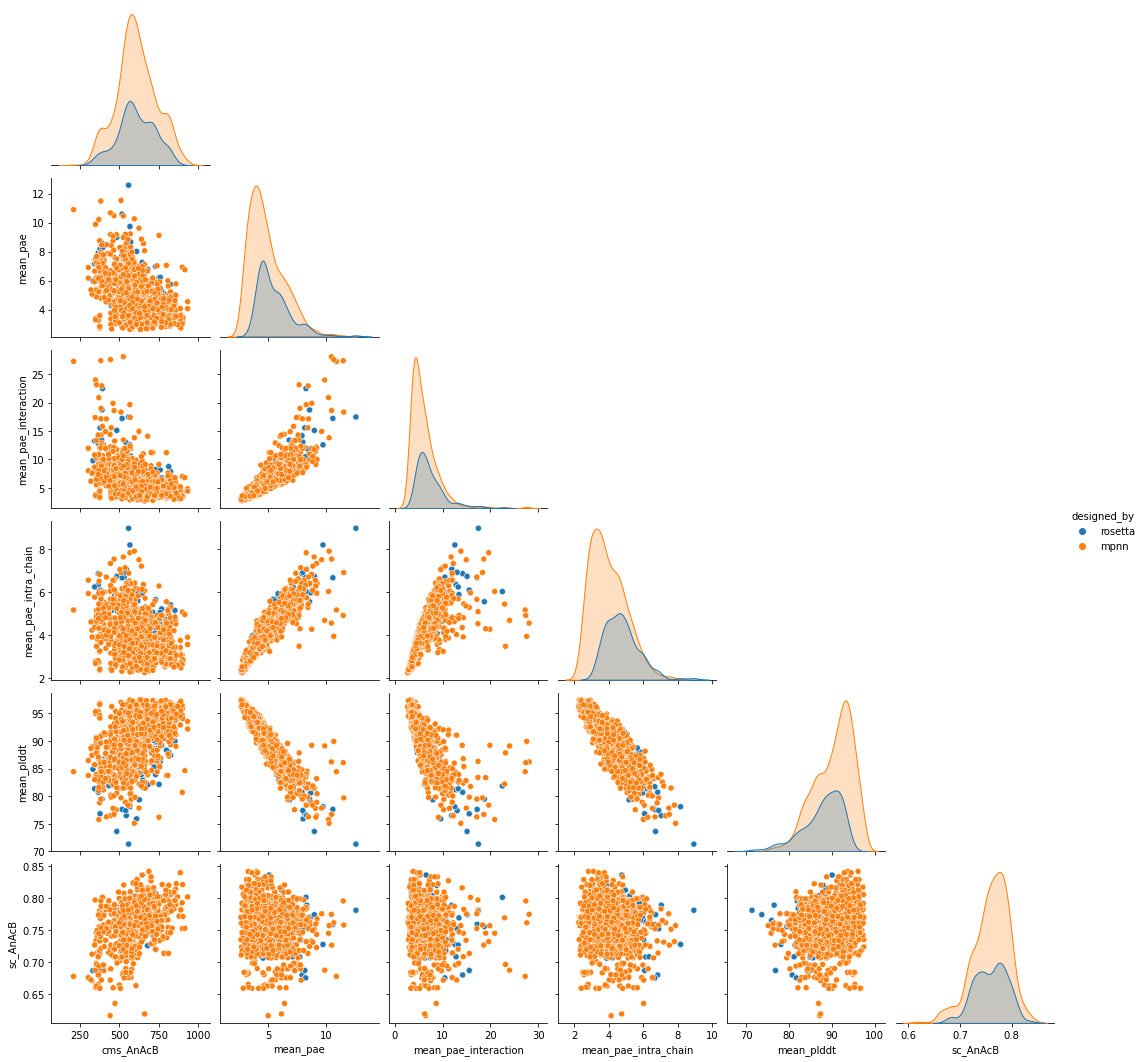

In [29]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "interface_scores_paired.png"))

### Plot effects of MPNN temperature and selector areas on interface metrics

6it [00:00, 34.15it/s]


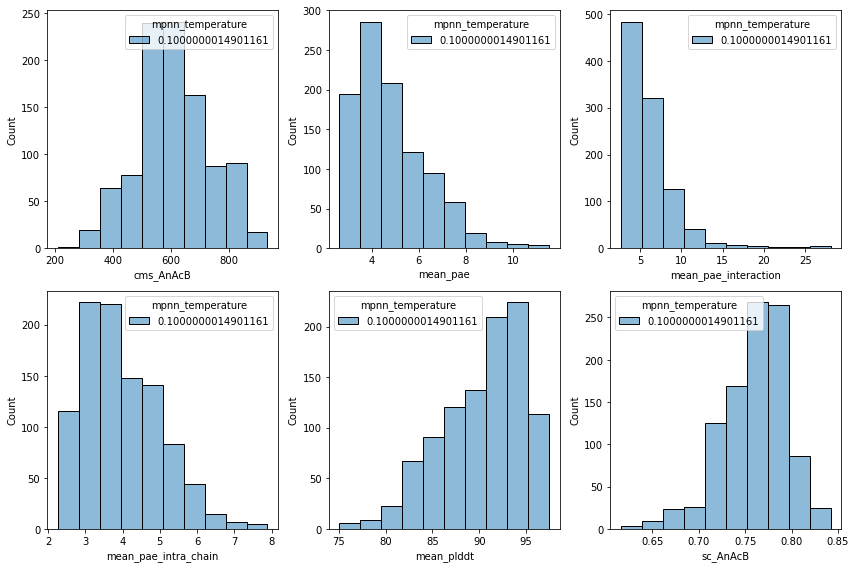

In [30]:
cols = [
    "cms_AnAcB",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_intra_chain",
    "mean_plddt",
    "sc_AnAcB",
]
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_temperature",
)
plt.savefig(os.path.join(output_path, "interface_scores_temp.png"))

<Figure size 1728x1728 with 0 Axes>

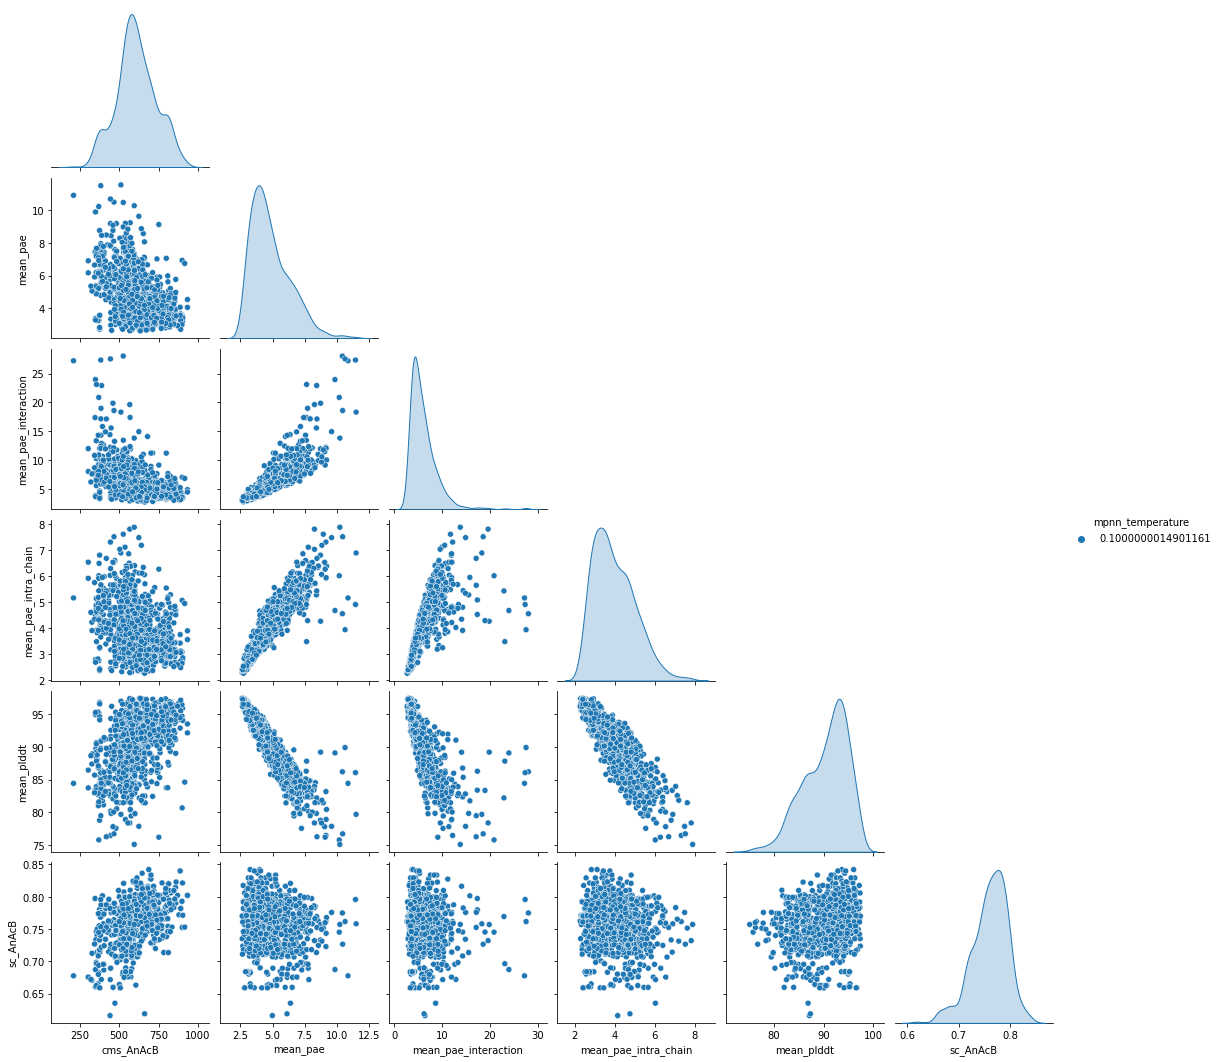

In [31]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_temperature",
)
plt.savefig(os.path.join(output_path, "interface_scores_temp_paired.png"))

6it [00:00, 23.00it/s]


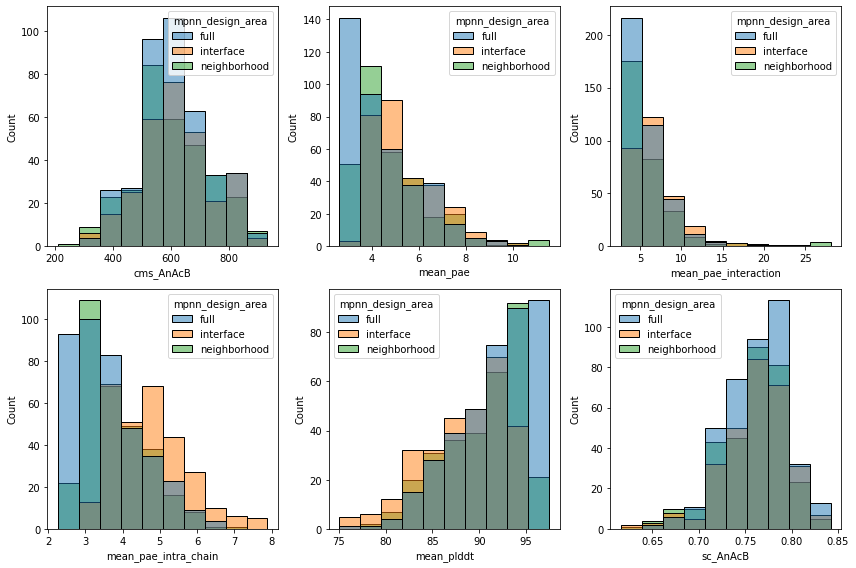

In [32]:
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_design_area",
)
plt.savefig(os.path.join(output_path, "interface_scores_area.png"))

<Figure size 1728x1728 with 0 Axes>

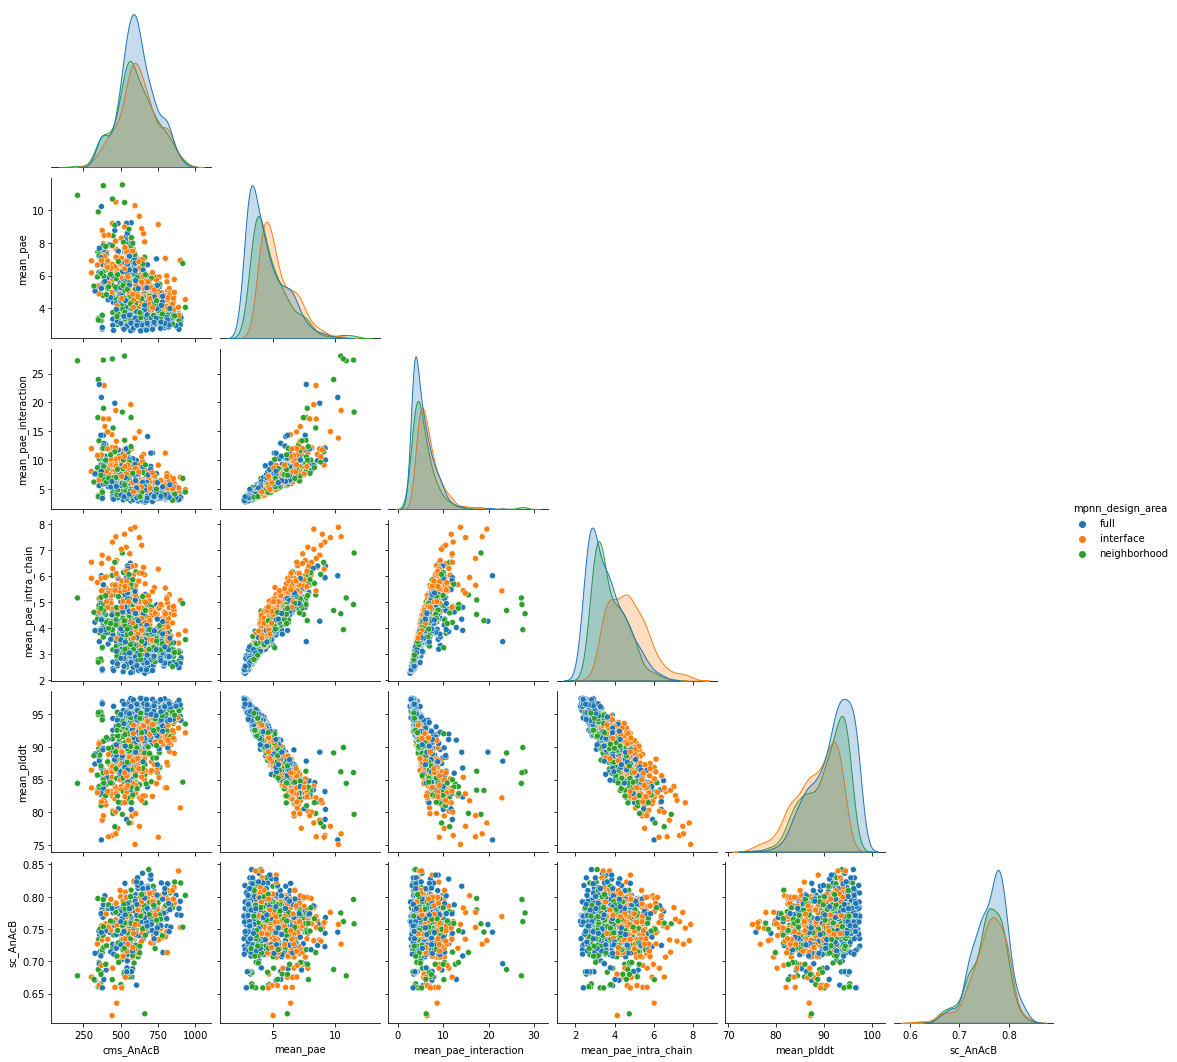

In [33]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_design_area",
)
plt.savefig(os.path.join(output_path, "interface_scores_area_paired.png"))

### Plot before and after for other scores

10it [00:00, 25.35it/s]


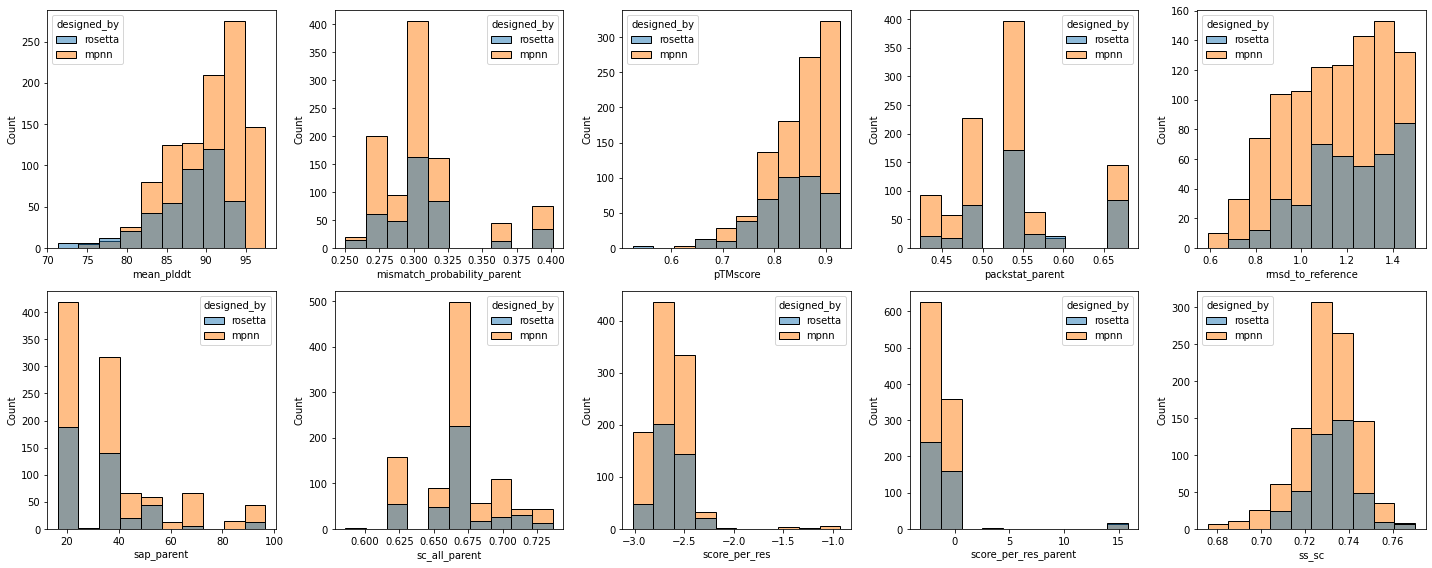

In [34]:
cols = [
    "mean_plddt",
    "mismatch_probability_parent",
    "pTMscore",
    "packstat_parent",
    "rmsd_to_reference",
    "sap_parent",
    "sc_all_parent",
    "score_per_res",
    "score_per_res_parent",
    "ss_sc",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_other_scores.png"))

<Figure size 2880x2880 with 0 Axes>

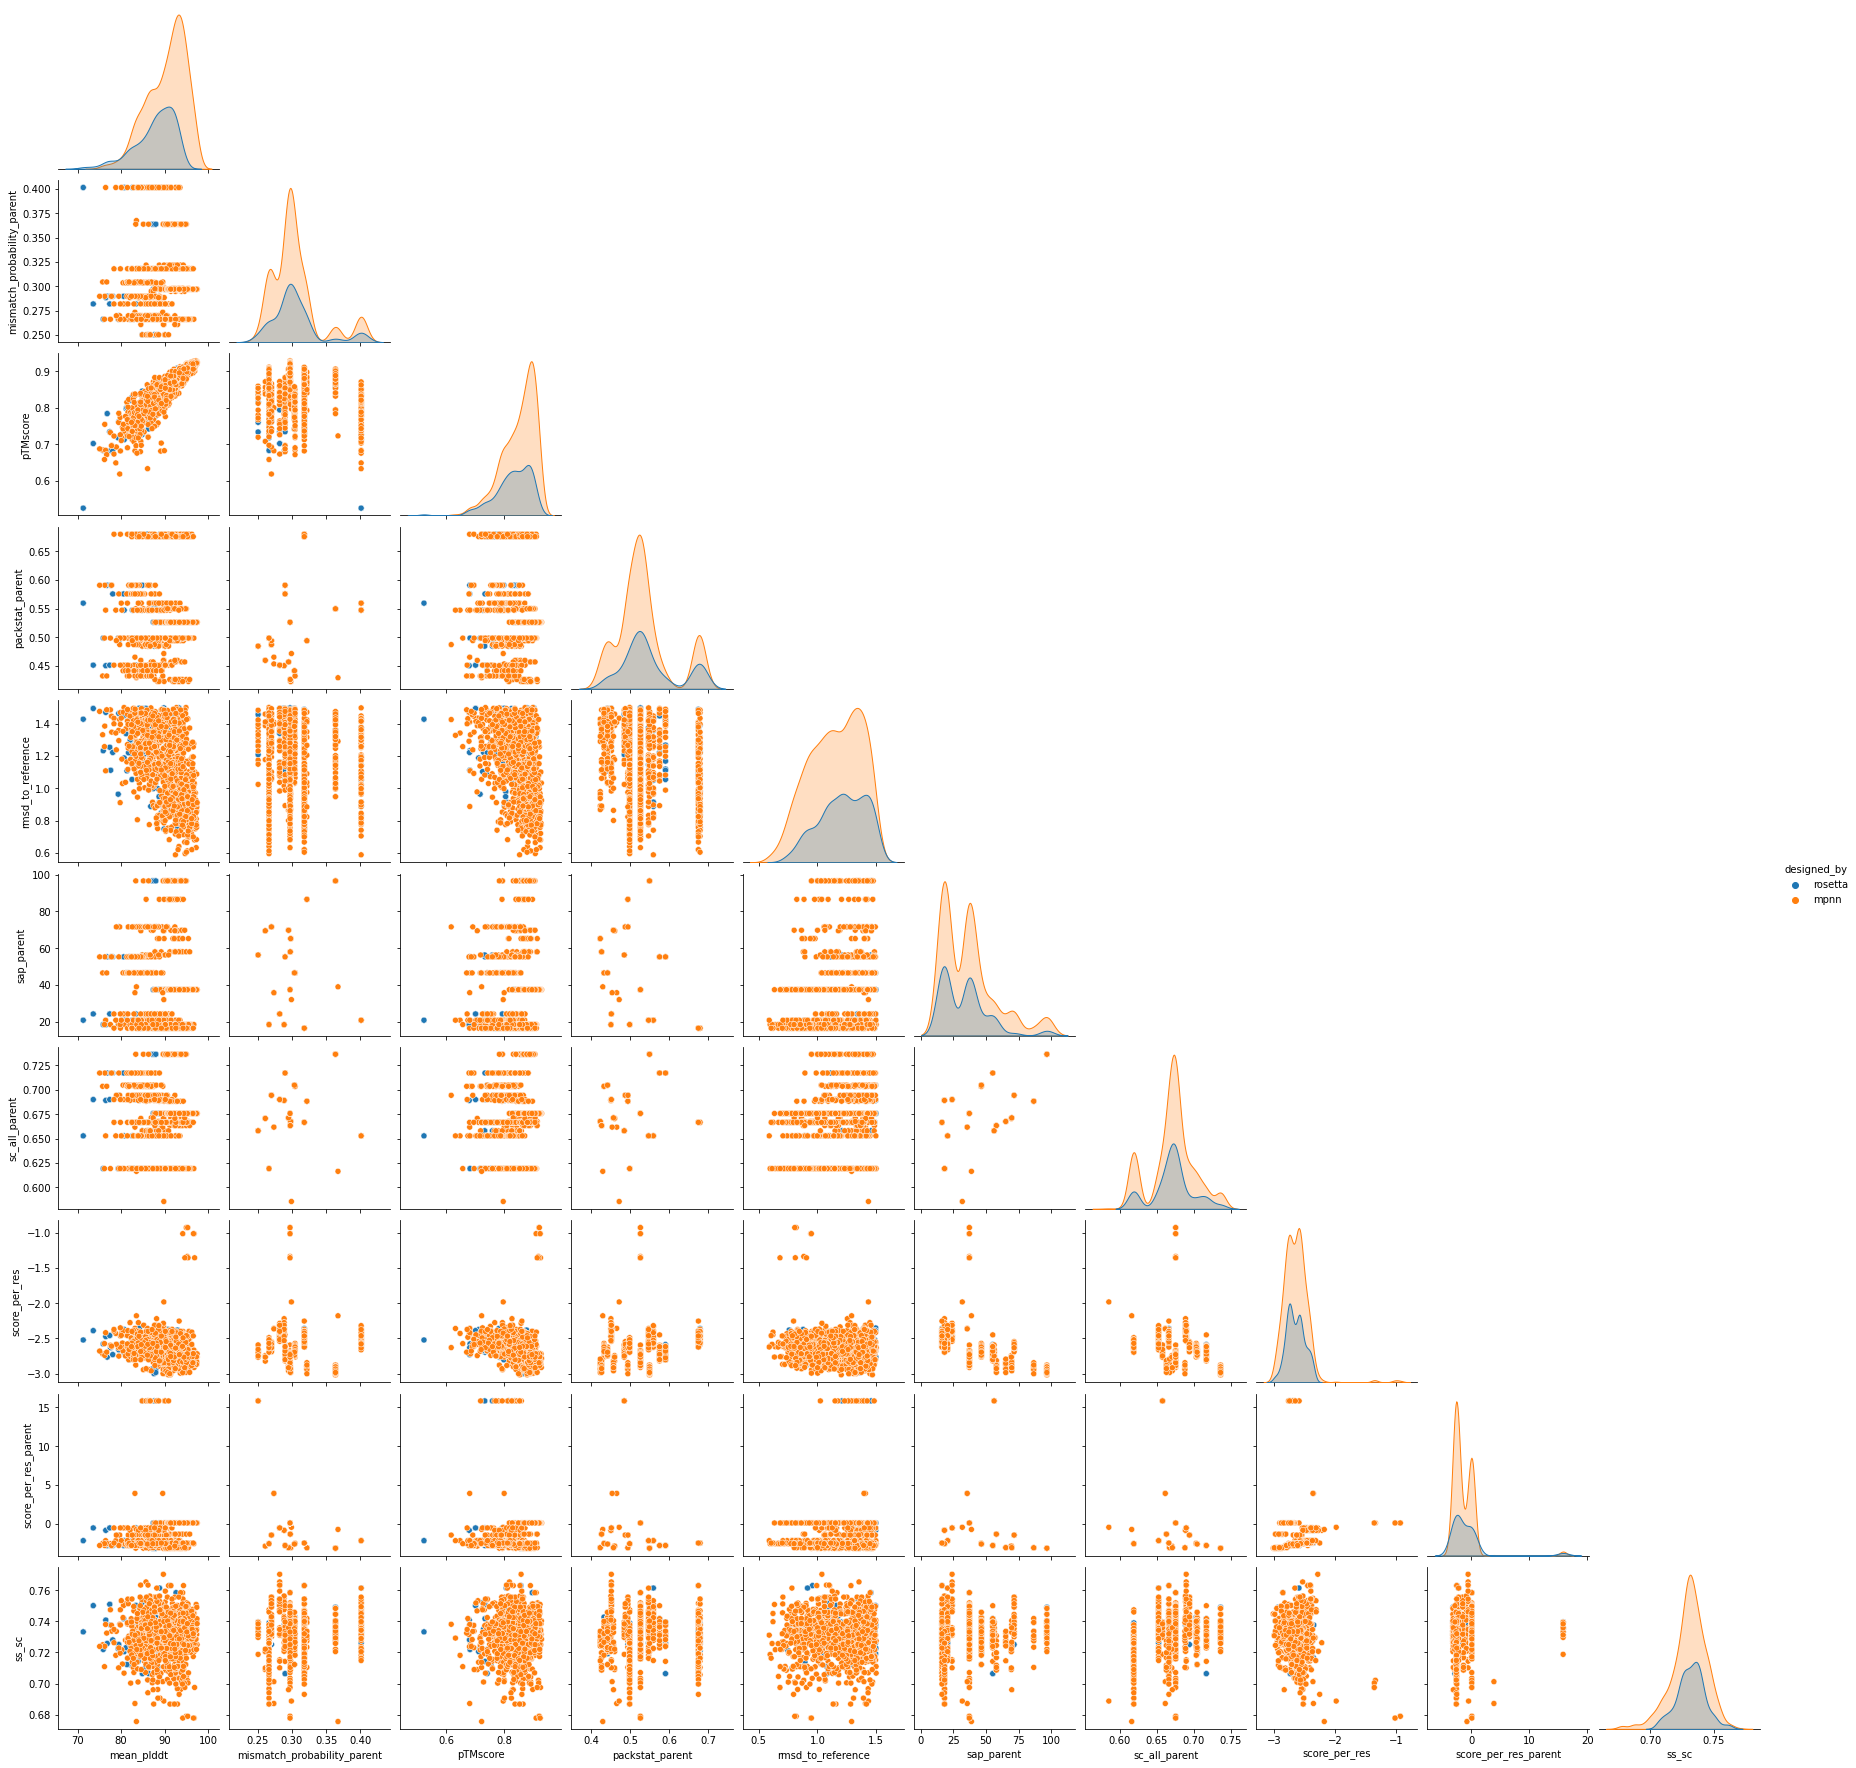

In [35]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_other_scores_paired.png"))

### Filter the whole df

In [50]:
# want to let as many states through the pipeline as possible. Filter on mean_plddt, pTMscore, mean_pae, and mean_pae_interaction, choosing either cutoffs of 90, 0.85, 5, and 10 respectively, or a little worse than the best scoring parent, whichever is worse.

filter_params = [
    ("mean_plddt", 90, 85, 3, 1),
    ("mean_pae", 5, 10, 2, 0),
    ("mean_pae_interaction", 5, 10, 2, 0),
    ("pTMscore", 0.85, 0.78, 0.05, 1),
]

filtered_idx = []

for state in tqdm(set(filt_df.state.values)):
    subset_df = filt_df.query(f"state == @state")
    for (
        score_term,
        best_cutoff,
        worst_cutoff,
        delta_cutoff,
        greaterthan,
    ) in filter_params:
        if greaterthan:
            best_value = subset_df[score_term].max()
            cutoff = best_value - delta_cutoff
            if cutoff < worst_cutoff:
                cutoff = worst_cutoff
            elif cutoff > best_cutoff:
                cutoff = best_cutoff
            subset_df = subset_df[subset_df[score_term] > cutoff]
        else:
            best_value = subset_df[score_term].min()
            cutoff = best_value + delta_cutoff
            if cutoff > worst_cutoff:
                cutoff = worst_cutoff
            elif cutoff < best_cutoff:
                cutoff = best_cutoff
            subset_df = subset_df[subset_df[score_term] < cutoff]
    filtered_idx.extend(list(subset_df.index))

filtered_df = filt_df.loc[filtered_idx]
filtered_df

  0%|          | 0/179 [00:00<?, ?it/s]

,bb_clash,bb_clash_delta,buns_parent,cms_AcB,cms_AnAc,cms_AnAcB,cms_AnB,designed_by,docked_helix,dslf_fa13,...,state,time,tol,topo,total_length,total_score,trim_n,trimmed_length,type,yhh_planarity
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0044/06_fold_bound_states_df036441284549bdab5a9ebbaf7a1f05.pdb.bz2,84.183907,4.254904,0.0,425.266296,255.443344,575.022095,179.286377,mpnn,6,0.0,...,s8_LRT6_p_7_s_7_d_6,1159.710321,0.363788,HHHHHHHHHHHH,284.0,-682.531137,0,255,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0027/06_fold_bound_states_037ec5472db9412ab8ed57d7992d8446.pdb.bz2,72.638466,15.629217,1.0,413.398010,359.490997,657.263916,265.962799,mpnn,6,0.0,...,P09_2_strand_p_5_s_-1_d_6,1807.471954,0.167897,HHHHHHHH,253.0,-565.790396,0,216,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0027/06_fold_bound_states_273747d919494e94bf95386f2a1e0261.pdb.bz2,72.638466,15.629217,1.0,413.398010,359.490997,657.263916,265.962799,mpnn,6,0.0,...,P09_2_strand_p_5_s_-1_d_6,1807.471954,0.133874,HHHHHHHH,253.0,-487.382024,0,216,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0027/06_fold_bound_states_cb4001d0c0454364902a2b330190c9e4.pdb.bz2,72.638466,7.502418,1.0,431.525818,384.648407,640.841187,211.860565,mpnn,6,0.0,...,P09_2_strand_p_5_s_-1_d_6,1636.876973,0.098567,HHHHHHHH,252.0,-614.133286,0,216,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0027/06_fold_bound_states_dd5af01c154a4d028d6ddb9954bc378e.pdb.bz2,72.638466,15.629217,1.0,413.398010,359.490997,657.263916,265.962799,mpnn,6,0.0,...,P09_2_strand_p_5_s_-1_d_6,1807.471954,0.158516,HHHHHHHH,253.0,-565.926758,0,216,monomer_ptm,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0058/06_fold_bound_states_5857abea94814c27a4ac0731a5768aa7.pdb.bz2,88.690193,4.248642,0.0,436.908295,446.097870,701.808533,280.083832,mpnn,8,0.0,...,R6CP33_m1_p_7_s_3_d_8,2330.556535,0.255810,HHHHHHHHHHHH,297.0,-258.772515,0,267,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0043/06_fold_bound_states_242cfa0fa3484f438238833913fcf80c.pdb.bz2,83.740044,8.783221,0.0,322.571045,395.309967,567.606262,243.944763,mpnn,8,0.0,...,R6_n6_p_7_s_3_d_8,992.201514,0.461617,HHHHHHHHHHHH,283.0,-638.666653,0,255,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0042/06_fold_bound_states_f35fb2af32274be3854f1c8d46ac7b29.pdb.bz2,83.740044,8.004604,0.0,389.153778,408.887390,615.476196,240.902283,mpnn,8,0.0,...,R6_n6_p_7_s_3_d_8,1699.147532,0.455657,HHHHHHHHHHHH,283.0,-619.488585,0,255,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0042/06_fold_bound_states_58460ce3ed274ae1bc39207667a0cfdc.pdb.bz2,83.740044,3.714858,0.0,372.476746,361.495392,536.989502,170.547470,mpnn,8,0.0,...,R6_n6_p_7_s_3_d_8,1789.287812,0.282528,HHHHHHHHHHHH,283.0,-617.509471,0,255,monomer_ptm,0.0


In [39]:
len(set(filt_df.state.values))

179

In [51]:
len(set(filtered_df.state.values))

158

In [52]:
# want to let as many states through the pipeline as possible. Filter on mean_plddt, pTMscore, mean_pae, and mean_pae_interaction, choosing either cutoffs of 90, 0.85, 5, and 10 respectively, or a little worse than the best scoring parent, whichever is worse.

filter_params = [
    ("mean_plddt", 85, 1),
    ("mean_pae", 10, 0),
    ("mean_pae_interaction", 10, 0),
    ("pTMscore", 0.78, 1),
]

filtered_worst_idx = []

for state in tqdm(set(filt_df.state.values)):
    subset_df = filt_df.query(f"state == @state")
    for (
        score_term,
        cutoff,
        greaterthan,
    ) in filter_params:
        if greaterthan:
            subset_df = subset_df[subset_df[score_term] > cutoff]
        else:
            subset_df = subset_df[subset_df[score_term] < cutoff]
    filtered_worst_idx.extend(list(subset_df.index))

filtered_worst_df = filt_df.loc[filtered_worst_idx]
filtered_worst_df

  0%|          | 0/179 [00:00<?, ?it/s]

,bb_clash,bb_clash_delta,buns_parent,cms_AcB,cms_AnAc,cms_AnAcB,cms_AnB,designed_by,docked_helix,dslf_fa13,...,state,time,tol,topo,total_length,total_score,trim_n,trimmed_length,type,yhh_planarity
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0044/06_fold_bound_states_df036441284549bdab5a9ebbaf7a1f05.pdb.bz2,84.183907,4.254904,0.0,425.266296,255.443344,575.022095,179.286377,mpnn,6,0.0,...,s8_LRT6_p_7_s_7_d_6,1159.710321,0.363788,HHHHHHHHHHHH,284.0,-682.531137,0,255,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0027/06_fold_bound_states_dc90c775c5f9407595fe4cb1c221c9fd.pdb.bz2,72.638466,15.629217,1.0,413.398010,359.490997,657.263916,265.962799,mpnn,6,0.0,...,P09_2_strand_p_5_s_-1_d_6,1807.471954,0.321581,HHHHHHHH,253.0,-501.710630,0,216,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0027/06_fold_bound_states_037ec5472db9412ab8ed57d7992d8446.pdb.bz2,72.638466,15.629217,1.0,413.398010,359.490997,657.263916,265.962799,mpnn,6,0.0,...,P09_2_strand_p_5_s_-1_d_6,1807.471954,0.167897,HHHHHHHH,253.0,-565.790396,0,216,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0027/06_fold_bound_states_273747d919494e94bf95386f2a1e0261.pdb.bz2,72.638466,15.629217,1.0,413.398010,359.490997,657.263916,265.962799,mpnn,6,0.0,...,P09_2_strand_p_5_s_-1_d_6,1807.471954,0.133874,HHHHHHHH,253.0,-487.382024,0,216,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0027/06_fold_bound_states_cb4001d0c0454364902a2b330190c9e4.pdb.bz2,72.638466,7.502418,1.0,431.525818,384.648407,640.841187,211.860565,mpnn,6,0.0,...,P09_2_strand_p_5_s_-1_d_6,1636.876973,0.098567,HHHHHHHH,252.0,-614.133286,0,216,monomer_ptm,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0058/06_fold_bound_states_18ac634149d448b7be2c33fe8b9b6f72.pdb.bz2,88.690193,8.305952,0.0,470.823883,342.360840,768.875000,330.780945,mpnn,8,0.0,...,R6CP33_m1_p_7_s_3_d_8,2838.254197,0.340816,HHHHHHHHHHHH,297.0,-537.027812,0,267,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0043/06_fold_bound_states_242cfa0fa3484f438238833913fcf80c.pdb.bz2,83.740044,8.783221,0.0,322.571045,395.309967,567.606262,243.944763,mpnn,8,0.0,...,R6_n6_p_7_s_3_d_8,992.201514,0.461617,HHHHHHHHHHHH,283.0,-638.666653,0,255,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0042/06_fold_bound_states_f35fb2af32274be3854f1c8d46ac7b29.pdb.bz2,83.740044,8.004604,0.0,389.153778,408.887390,615.476196,240.902283,mpnn,8,0.0,...,R6_n6_p_7_s_3_d_8,1699.147532,0.455657,HHHHHHHHHHHH,283.0,-619.488585,0,255,monomer_ptm,0.0
/pscratch/sd/b/broerman/06_fold_bound_states/decoys/0042/06_fold_bound_states_58460ce3ed274ae1bc39207667a0cfdc.pdb.bz2,83.740044,3.714858,0.0,372.476746,361.495392,536.989502,170.547470,mpnn,8,0.0,...,R6_n6_p_7_s_3_d_8,1789.287812,0.282528,HHHHHHHHHHHH,283.0,-617.509471,0,255,monomer_ptm,0.0


In [53]:
len(set(filtered_worst_df.state.values))

158

So, the dynamic filtering of filtered_df keeps the same number of states as choosing the worst cutoffs, but filters out 30% more suboptimal designs. Perfect!

In [61]:
len(set(filtered_df.parent.values))

24

In [62]:
len(set(filtered_worst_df.parent.values))

24

6it [00:00, 22.32it/s]


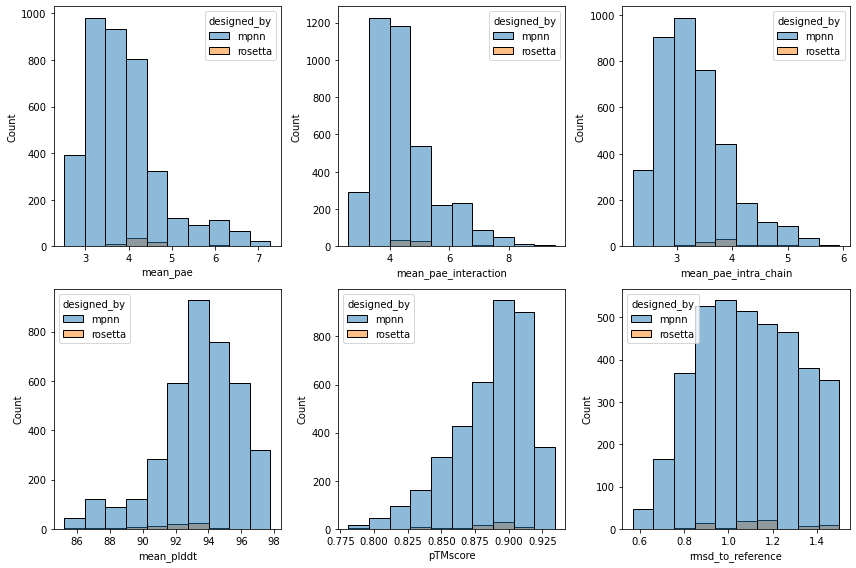

In [54]:
cols = [
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_intra_chain",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
]
the_fig = histplot_df(
    df=filtered_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "filtered_af2_scores.png"))

6it [00:00, 20.90it/s]


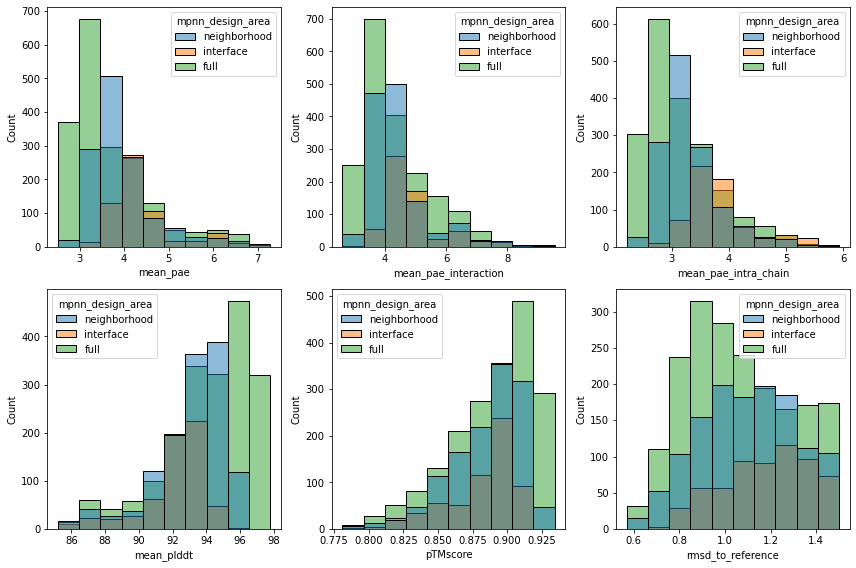

In [57]:
the_fig = histplot_df(
    df=filtered_df[filtered_df["designed_by"] == "mpnn"],
    cols=cols,
    bins=10,
    hue="mpnn_design_area",
)
plt.savefig(os.path.join(output_path, "filtered_af2_scores_by_design_area.png"))

### Rebalance the filtered df
I originally failed to add in the randomly selected from the highly represented states so getting those now

In [59]:
for state in tqdm(set(filtered_df.state.values)):
    subset_df = filtered_df.query(f"state == @state")
    # if len is less than or equal to goal_representation take all,
    print(len(subset_df), state, subset_df.parent.values[0])

  0%|          | 0/158 [00:00<?, ?it/s]

1 s8_LRT6_p_7_s_7_d_6 s8_LRT6
109 P09_2_strand_p_5_s_-1_d_6 P09_2_strand
7 R6_02_p_6_s_5_d_5 R6_02
1 R6PEP12_model00_p_7_s_3_d_8 R6PEP12_model00
10 s8_LRT6_p_6_s_4_d_5 s8_LRT6
12 R6_02_p_6_s_-3_d_5 R6_02
5 R6ST3_p_6_s_4_d_5 R6ST3
3 RRN_s202_p_4_s_4_d_3 RRN_s202
10 R6_PO11_p_7_s_4_d_6 R6_PO11
185 P09_2_strand_p_5_s_-5_d_6 P09_2_strand
14 KWH1_chainA_01_p_5_s_3_d_4 KWH1_chainA_01
205 P09_2_strand_p_5_s_-4_d_6 P09_2_strand
6 R6ST3_p_7_s_-1_d_6 R6ST3
10 sl_S2_08_p_7_s_3_d_8 sl_S2_08
124 KW_b1_11_DY_p_4_s_1_d_3 KW_b1_11_DY
1 R6M4_p_7_s_-4_d_8 R6M4
1 s8_LRT6_p_7_s_7_d_8 s8_LRT6
19 R6_02_p_6_s_1_d_5 R6_02
22 sl_S2_08_p_6_s_4_d_5 sl_S2_08
4 KW_b1_07_repeat_p_5_s_1_d_6 KW_b1_07_repeat
7 R6_n6_p_7_s_-4_d_8 R6_n6
4 sl_S2_08_p_6_s_1_d_5 sl_S2_08
1 PF04_PDR_p_6_s_-1_d_5 PF04_PDR
31 s93_p_6_s_5_d_5 s93
130 P09_2_strand_p_4_s_-3_d_3 P09_2_strand
40 P09_2_strand_p_4_s_1_d_5 P09_2_strand
11 R6PXX13_p_6_s_-3_d_5 R6PXX13
2 R6CP33_m1_p_7_s_-5_d_8 R6CP33_m1
4 R6CP33_m1_p_6_s_4_d_5 R6CP33_m1
2 R6ST3_p_7_s_-

In [65]:
rebalanced = []
goal_representation = 100

for state in tqdm(set(filtered_df.state.values)):
    subset_df = filtered_df.query(f"state == @state")
    # if len is less than or equal to goal_representation take all,
    if len(subset_df) <= goal_representation:
        rebalanced.extend(list(subset_df.index))
    else:
        # prefer interface and neighborhood only redesigns
        interface = subset_df.query("mpnn_design_area == 'interface'")
        neighborhood = subset_df.query("mpnn_design_area == 'neigborhood'")
        int_neighborhood = pd.concat([interface, neighborhood])
        # if total between interface and neighborhood is less than goal_representation take all, plus some full to make up the difference
        if 0 < len(int_neighborhood) < goal_representation:
            rebalanced.extend(list(int_neighborhood.index))
            full = subset_df.query("mpnn_design_area == 'interface'")
            if len(full) > goal_representation - len(int_neighborhood):
                sample = full.sample(
                    goal_representation - len(int_neighborhood), random_state=0
                )
                rebalanced.extend(list(sample.index))
            else:
                rebalanced.extend(list(full.index))
        else:
            # get 100 randomly selected from this state
            sample = subset_df.sample(goal_representation, random_state=0)
            rebalanced.extend(list(sample.index))


rebalanced_df = filtered_df.loc[rebalanced]

print(len(rebalanced_df))

  0%|          | 0/158 [00:00<?, ?it/s]

2349


### Save a list of outputs
Sort by length  

In [66]:
simulation_name = "06_fold_bound_states"
output_path = os.path.join(
    "/home/broerman/crispy_shifty/projects/OPS/round_1/design", simulation_name
)
rebalanced_df = rebalanced_df.sort_values("looped_length")
with open(os.path.join(output_path, "folded_states.list"), "w") as f:
    for path in tqdm(rebalanced_df.index):
        print(path, file=f)

  0%|          | 0/2349 [00:00<?, ?it/s]